In [6]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
import json

import warnings
warnings.filterwarnings("ignore")

In [7]:
DATASET_DIR = "/content/drive/MyDrive/datasets/Medicinal Leaf Images"

img_width, img_height = 224, 224  # MobileNet default input size
batch_size = 32
learning_rate = 0.0001
epochs = 20

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

class_dict = train_generator.class_indices
class_names = list(class_dict.keys())
num_classes = len(class_names)

# Save class names to file for later use in the API
with open('plant_class_names.json', 'w') as f:
    json.dump(class_names, f)

print(f"Found {num_classes} classes: {class_names}")

Found 1479 images belonging to 30 classes.
Found 356 images belonging to 30 classes.
Found 30 classes: ['Alpinia Galanga (Rasna)', 'Amaranthus Viridis (Arive-Dantu)', 'Artocarpus Heterophyllus (Jackfruit)', 'Azadirachta Indica (Neem)', 'Basella Alba (Basale)', 'Brassica Juncea (Indian Mustard)', 'Carissa Carandas (Karanda)', 'Citrus Limon (Lemon)', 'Ficus Auriculata (Roxburgh fig)', 'Ficus Religiosa (Peepal Tree)', 'Hibiscus Rosa-sinensis', 'Jasminum (Jasmine)', 'Mangifera Indica (Mango)', 'Mentha (Mint)', 'Moringa Oleifera (Drumstick)', 'Muntingia Calabura (Jamaica Cherry-Gasagase)', 'Murraya Koenigii (Curry)', 'Nerium Oleander (Oleander)', 'Nyctanthes Arbor-tristis (Parijata)', 'Ocimum Tenuiflorum (Tulsi)', 'Piper Betle (Betel)', 'Plectranthus Amboinicus (Mexican Mint)', 'Pongamia Pinnata (Indian Beech)', 'Psidium Guajava (Guava)', 'Punica Granatum (Pomegranate)', 'Santalum Album (Sandalwood)', 'Syzygium Cumini (Jamun)', 'Syzygium Jambos (Rose Apple)', 'Tabernaemontana Divaricata (Cr

In [8]:
# Load pre-trained MobileNetV2 without the top (classification) layer
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(img_width, img_height, 3)
)

# First, freeze all the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,983,390 (11.38 MB)

 Trainable params: 725,406 (2.77 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
# Calculate steps per epoch
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size or 1

# Train the model (first stage - feature extraction)
print("Stage 1: Training with frozen base model (feature extraction)")
history_stage1 = model.fit(
    train_generator,
    epochs=10,  # Train for fewer epochs initially
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    verbose=1
)

Stage 1: Training with frozen base model (feature extraction)
Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.1092 - loss: 3.3288 - val_accuracy: 0.3864 - val_loss: 2.4915
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.4062 - loss: 2.5077 - val_accuracy: 0.3977 - val_loss: 2.4733
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 40s 869ms/step - accuracy: 0.4066 - loss: 2.3387 - val_accuracy: 0.6364 - val_loss: 1.6084
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.5625 - loss: 1.8800 - val_accuracy: 0.6420 - val_loss: 1.5940
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 76s 841ms/step - accuracy: 0.6239 - loss: 1.5701 - val_accuracy: 0.7330 - val_loss: 1.0719
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.7500 - loss: 1.2291 - val_accuracy: 0.7443 - val_loss: 1.0671
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 77s 846ms/step - accuracy: 0.7367 - loss: 1.0872 - val_accuracy: 0.8295 - val_loss: 0.7436
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 

In [10]:
# Fine-tuning: unfreeze some of the top layers of the base model
print("Stage 2: Fine-tuning - unfreezing top layers of the base model")
# We'll unfreeze the top 30 layers while keeping the others frozen
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate/10),  # Lower learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print which layers are trainable
trainable_count = sum(layer.trainable for layer in base_model.layers)
print(f"Total base model layers: {len(base_model.layers)}")
print(f"Trainable base model layers: {trainable_count}")

# Continue training with unfrozen layers (second stage - fine-tuning)
history_stage2 = model.fit(
    train_generator,
    epochs=epochs,
    initial_epoch=len(history_stage1.history['loss']),  # Start from where stage 1 ended
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    verbose=1
)

Stage 2: Fine-tuning - unfreezing top layers of the base model
Total base model layers: 154
Trainable base model layers: 30
Epoch 11/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.5098 - loss: 1.7601 - val_accuracy: 0.8409 - val_loss: 0.5737
Epoch 12/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.9062 - loss: 0.7822 - val_accuracy: 0.8409 - val_loss: 0.5770
Epoch 13/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.6796 - loss: 1.2800 - val_accuracy: 0.8239 - val_loss: 0.5884
Epoch 14/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.8438 - loss: 0.8862 - val_accuracy: 0.8182 - val_loss: 0.5989
Epoch 15/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 57s 860ms/step - accuracy: 0.7728 - loss: 0.9483 - val_accuracy: 0.8068 - val_loss: 0.5897
Epoch 16/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.7188 - loss: 1.1423 - val_accuracy: 0.7983 - val_loss: 0.5948
Epoch 17/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 38s 837ms/step - accuracy: 0.8050 - loss: 0.8390 - val_accuracy: 0.8

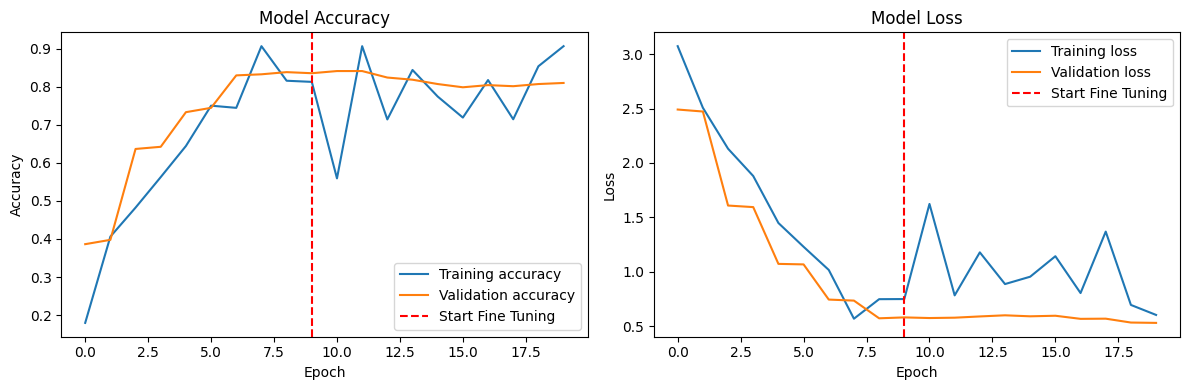

In [11]:
# Combine the histories from both training stages
history = {}
for key in history_stage1.history:
    history[key] = history_stage1.history[key] + history_stage2.history[key]

# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training accuracy')
plt.plot(history['val_accuracy'], label='Validation accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.axvline(x=len(history_stage1.history['accuracy'])-1, color='r', linestyle='--',
           label='Start Fine Tuning')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.axvline(x=len(history_stage1.history['loss'])-1, color='r', linestyle='--',
           label='Start Fine Tuning')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
# Evaluate the model
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    DATASET_DIR,  # Using the same dataset
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

print("Evaluating the model...")
score, accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test score: {score:.4f}")
print(f"Test accuracy: {accuracy:.4f}")


Found 1835 images belonging to 30 classes.
Evaluating the model...
58/58 ━━━━━━━━━━━━━━━━━━━━ 27s 461ms/step - accuracy: 0.8741 - loss: 0.4448
Test score: 0.4227
Test accuracy: 0.8687


Generating predictions for analysis...
58/58 ━━━━━━━━━━━━━━━━━━━━ 30s 462ms/step
Classification report:
                                              precision    recall  f1-score   support

                     Alpinia Galanga (Rasna)       1.00      0.60      0.75        50
            Amaranthus Viridis (Arive-Dantu)       0.96      0.95      0.95       122
        Artocarpus Heterophyllus (Jackfruit)       0.62      1.00      0.76        56
                   Azadirachta Indica (Neem)       0.98      1.00      0.99        60
                       Basella Alba (Basale)       0.99      0.90      0.94       103
            Brassica Juncea (Indian Mustard)       0.97      1.00      0.99        34
                  Carissa Carandas (Karanda)       0.97      0.78      0.87        74
                        Citrus Limon (Lemon)       0.98      0.75      0.85        57
             Ficus Auriculata (Roxburgh fig)       0.84      0.72      0.77        50
               Ficus Religiosa (Pee

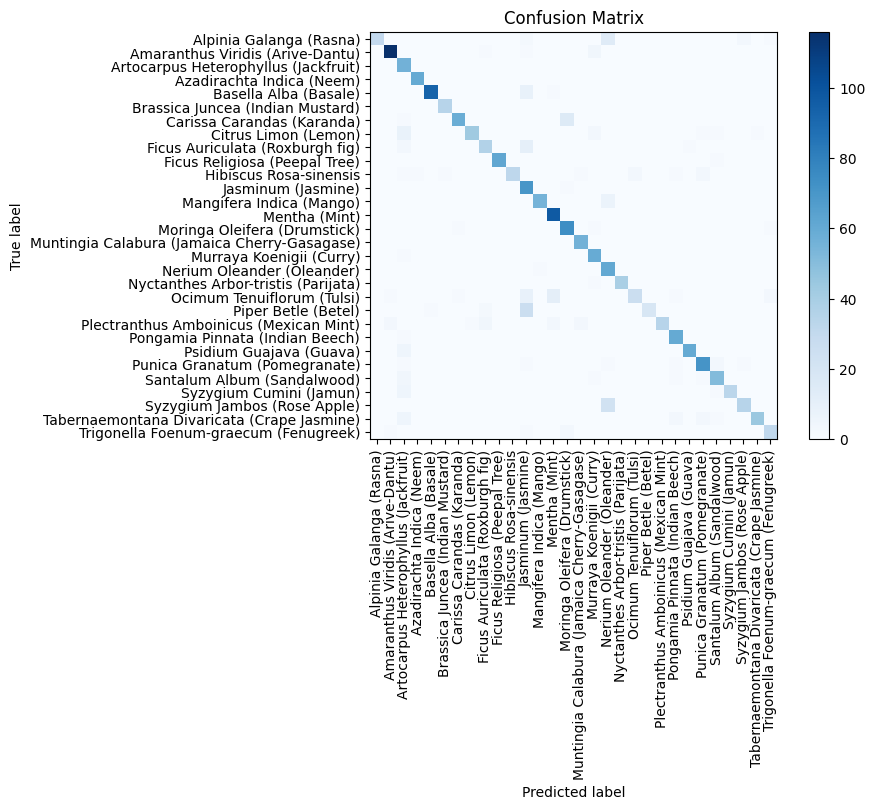

In [13]:
# Get predictions for confusion matrix
print("Generating predictions for analysis...")
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
true_classes = test_generator.classes

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
print("Classification report:")
print(classification_report(
    true_classes,
    y_pred_classes,
    target_names=class_names
))

# Confusion matrix visualization
cm = confusion_matrix(true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=90)
plt.yticks(tick_marks, test_generator.class_indices.keys())
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [14]:
model.save('mobilenet_plant_model.keras')
print("Model saved successfully in .keras format")

Model saved successfully in .keras format


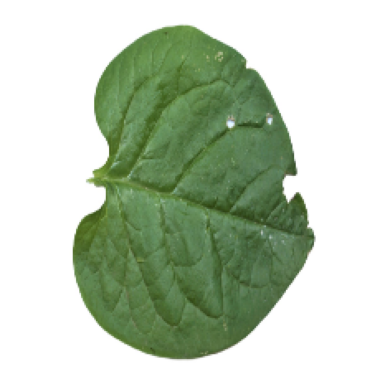

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class: Basella Alba (Basale)
Confidence: 95.80%


('Basella Alba (Basale)', np.float32(95.80481))

In [15]:
def predict_image(img_path):
    # Load and preprocess the image
    img = load_img(img_path, target_size=(img_width, img_height))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Convert to array and preprocess
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class] * 100

    print(f"Predicted class: {class_names[predicted_class]}")
    print(f"Confidence: {confidence:.2f}%")

    return class_names[predicted_class], confidence

predict_image("/content/drive/MyDrive/datasets/Medicinal Leaf Images/Basella Alba (Basale)/BA-S-001.jpg")